# Program Management
We have received a large RAW image set from a customer.
The Atlas team must process the RAW dataset to convert to RGB and pass the images to an data annotation team for for data labelling so that they can be used by a computer vision team for neural network training.

1. Briefly describe the project milestones or workflow you would set for the Atlas team to coordinate with the other two teams and deliver timely and sucessfully on the project.

# Programming assignment

The objective of this assignment is to propose an image processing pipeline to process companded HDR RAW images in either Python or C/C++. A set of such RAW images captured in challenging conditions is included in `images/`.

The RAW images have the following format:

```
BITDEPTH = 16 bits
COLS = 2880
ROWS = 1860
HEADER_ROWS = 5
TRAILER_ROWS = 6
CFA_ORDER = RGGB
```

Tasks:
1. Develop a function to open a companded RAW image from disk and return a linear RAW image. In Python, you can use `numpy.fromfile` and the `linearize` function provided below.
2. Implement a minimal image processing pipeline to convert the RAW images to RGB. The images are intended for annotation so scene objects must be clearly visible and identifiable. Objects or interest are pedestrains, cyclists, vehicles, traffic lights and road signs. Justify the order of the blocks implemented and the algorithms used. You can use any available libraries. Make sure the pipeline can handle diverse capture conditions by testing it on the provided RAW images.
3. Display or store the processed RGB image to disk.

# Solutions

<blockquote>
    <h2>Candidate: Mohsen Ghazel</h2>
    <p>Initial Submission Date: December 17th, 2020</p>
    <p>Updated Submission Date: December 22nd, 2020</p>
    
     - Summary of changes:
       - Edited and refactored code and added comments, documentation and output statements
       - Replaced pixels clipping with linear scaling to within the interval: [0, 1]
       - Implemented a HSV-based post-processing module, which consists of the following transformations:
         - Suppress the values of the HSV Hue and Saturation channels in order to reduce the magenta cast
         - Apply Adaptive Histogram Equalization on the HSV Value-channel to enhance the image contrast.
    
</blockquote>

# 1. Program Management


I propose to adapt the 7 fundamental stages of the System Development Life Cycle to manage this project, as follows:


1. Planning 

  - To ensure that the project has enough people and resources. 
  - To involve the full ATLAS project team to share information, have productive discussions and promote a collaborative work plan, which involves everyone.
  - To outline the project objectives and plans
  - To assign role and sub-tasks to each team member and request effort estimations. 
  - To ensure that each team member is clear on the project work plan and goals.  


2. Requirement Analysis

 - To ensure that the project requirements meet the needs of the stakeholders, namely the annotation team.
 - To meet the annotation team and understand how the output RGB images are used and the type of objects that will be annotated from these images.
 - To discuss and define the expected image quality parameters and metrics that ensure the output RGB images meet the requirements of the stakeholders. 
 

3. Designing & Prototyping

 - To design and prototype a customized ISP pipeline, that ensures that output RGB images satisfy the gathered requirements. 
 - To ensure a modular, flexible and scalable design and define all interfaces and APIs 
 - To share sample ouput of the designed ISP prototype with the stakeholders (annotation team) in order to gether early feedback
 - To adjust the designed ISP pipeline based on the gathed feedback, as needed.
 
 
4. Software Development

 - To turn our gathered project requirements and developed ISP prototype into working code and re-usable software functionalities and tools. 
 
 
5. Software Testing Stage

 - To test the developed code based on the following set of criteria:.

    - Output meets the stated requirements
    - Corner cases are handled properly and meet expectations
    - Written code meeting the adopted coding standards
    - Code is performant and optimized
    - Code meets secure development principals.

 - To ensure that the output of software testing is a better solution that is optimized, handles edge cases and meets user requirements. 
 
 
6. Deployment

 - To define the API of the developed custom ISP pipeline
 - To integrate the developed code into the main Atlas ISP system
 - To test deploying the integrated code and identify and fix any integration issues
 - To document the developed custom ISP pipeline including:
 
    - System design and workflow
    - Input/output API
    - Performance evaluation metrics
    - Identified advantages and limitations
    - Lessons learned
    - A user guide.

 
7. Operation and Maintenance

 - To monitor the developed software ISP tools for bugs or defects
 - To create a bug report and fix identified issues
 - To regularly assess performance in terms of the requireed image quality metrics of the output RGB images
 - To identify and understand deficiencies and limitations and explore solutions tro address them
 - To identify opportunities for improvement to be considered during the next software development cycle.
 

# 2. Programming Assignment

The ISP pipeline implemented in the proposed solution is illustrated in the figure below.

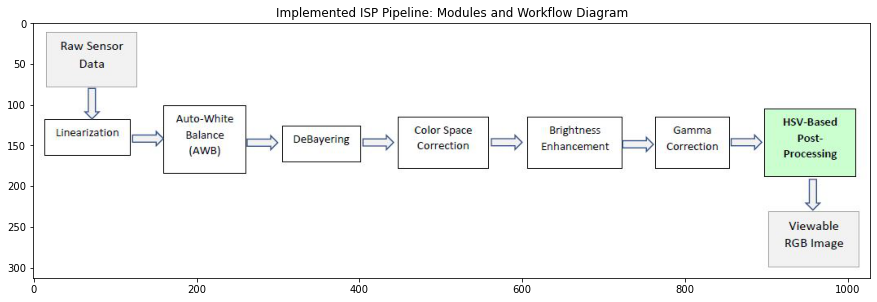

In [1]:
#----------------------------------------------------------
# To display the implemented ISP pipeline workflow diagram
#----------------------------------------------------------  
# Author: Mohsen Ghazel
# Date: Dec. 22nd, 2020
#---------------------------------------------------------- 
# importing matplotlib modules 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
   
# Read the image of the ISP pipeline workflow diagram
img = mpimg.imread('figures\\Implemented_ISP_Pipeline_New.JPG')  
# create a figure and set its size
plt.figure(figsize = (15,7))
# display the image of the ISP pipeline workflow diagram
plt.imshow(img) 
# set the figure title
plt.title('Implemented ISP Pipeline: Modules and Workflow Diagram')
# view the figure
plt.show()

## Helper functions

In [2]:
import numpy as np

def linearize(buffer: np.ndarray, pedestal: int = 240) -> np.ndarray:
    """
    24-bit linear output.
    """
    buffer = buffer.astype(np.float32)
    buffer = buffer - pedestal
    _knee_points_in = [0, 3904, 287152, 2238336, 16777200]
    _knee_points_out = [0, 3904, 23520, 54416, 65280]
    decompanded = np.zeros_like(buffer).astype(np.float32)
    for i in range(len(_knee_points_in) - 1):
        mask = (_knee_points_in[i] <= buffer) & (buffer < _knee_points_in[i + 1])
        decompanded[mask] = _knee_points_out[i] + (_knee_points_out[i + 1] - _knee_points_out[i]) *\
                            (buffer[mask] - _knee_points_in[i]) / (_knee_points_in[i + 1] - _knee_points_in[i])
    decompanded[buffer == _knee_points_in[-1]] = _knee_points_out[-1]
    return decompanded

In [3]:
def compute_awb_weights(img, cfa_pattern, awb_approach):
    #----------------------------------------------------------
    # Compute the AWB weights based on the selected approach.
    #
    #  approach = 1: Gray-world assumption approach
    #  approach = 2: White-world assumption approach
    #
    #----------------------------------------------------------
    # Input: 
    #----------------------------------------------------------
    # 1) img: Single-channel rggb Bayered image
    #
    # 2) cfa_pattern:  A string indicating the 2x2 Bayer pattern: 
    #
    #                 2.1) 'RGGB':  
    #                     R G 
    #                     G B 
    #                 2.2) 'GBRG':
    #                     G B
    #                     R G
    #                 2.3) 'GRBG':
    #                     G R
    #                     B G    
    #                 2.4) 'BGGR':
    #                     B G
    #                     G R    
    #
    # 3) awb_approach: is an integeger the specifies the approach 
    #                 used to compute the AWB weights 
    #
    #     3.1) awb_approach = 1: Apply the Gray-World Assumption approach
    #     3.2) awb_approach = 2: Apply the White-World Assumption approach
    #
    #----------------------------------------------------------
    # Returns: A 3-element floating-point vector consisting of the AWB 
    #          weights of R, G and B channels in the following order:
    #
    #          awb_weights = [R_weight G_weight B_weight].
    #
    #----------------------------------------------------------
    # History
    #----------------------------------------------------------
    # Dec. 17th, 2020         Initial implementation
    # Dec. 22nd, 2020         Code factoring and documentations
    #----------------------------------------------------------
    # Author: Mohsen Ghazel
    #----------------------------------------------------------
    
    #----------------------------------------------------------
    # Step 1: convert image to double for flowting-point 
    #         precision calculation
    #----------------------------------------------------------
    img = img.astype(np.double)

    #----------------------------------------------------------
    # Step 2: Get the image dimensions
    #----------------------------------------------------------
    # number of rows
    nrows = img.shape[0]
    # number of columns
    ncols = img.shape[1]

    #--------------------------------------------------------------
    # Step 3: Create color masks:
    #--------------------------------------------------------------
    # - We need to create indicator masks that tell us
    #   where each of the color pixels are in the bayered input image:
    # 
    #    - 1 indicates presence of that color
    #    - 0 indicates otherwise
    # 
    # - This depends on the CFA pattern.
    #--------------------------------------------------------------
    # 3.1) For RGGB CFA pattern
    #--------------------------------------------------------------
    if ( cfa_pattern.lower() == 'rggb' ):
        # - Indicator masks for the red channel
        red_mask = np.tile([[1,0],[0,0]], (int(nrows/2), int(ncols/2)))
        # - Indicator masks for the green channel
        green_mask = np.tile([[0,1],[1,0]], (int(nrows/2), int(ncols/2)))
        # - Indicator masks for the blue channel
        blue_mask = np.tile([[0,0],[0,1]], (int(nrows/2), int(ncols/2)))
    #--------------------------------------------------------------
    # 3.2) For BGGR CFA pattern
    #--------------------------------------------------------------
    elif ( cfa_pattern.lower() == 'bggr' ):
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - For this assignment, we only implemented the RGGB case
        # - Other CFA patterns may be implemented in the future
        #--------------------------------------------------------------
        print('TBD...\n')
    #--------------------------------------------------------------
    # 3.3) For GRBG CFA pattern
    #--------------------------------------------------------------
    elif ( cfa_pattern.lower() == 'grbg' ):
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - For this assignment, we only implemented the RGGB case
        # - Other CFA patterns may be implemented in the future
        #--------------------------------------------------------------
        print('TBD...\n')
    #--------------------------------------------------------------
    # 3.4) For GBRG CFA pattern
    #--------------------------------------------------------------
    elif ( cfa_pattern.lower() == 'gbrg' ):
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - For this assignment, we only implemented the RGGB case
        # - Other CFA patterns may be implemented in the future
        #--------------------------------------------------------------
        print('TBD...\n')
    #----------------------------------------------------------
    # 3.5) Handle invalid CFA pattern.
    #----------------------------------------------------------
    else:
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - Handle invalid CFA pattern.
        #--------------------------------------------------------------
        print('TBD...\n')
    
    #--------------------------------------------------------------
    # Step 4: Multiply the image by the color mask
    #--------------------------------------------------------------
    # The RED channel
    #--------------------------------------------------------------
    red_img = np.multiply(img, red_mask)
    # the number of red-pixels readings
    num_red_pixels = (nrows * ncols ) / 4.0
    #--------------------------------------------------------------
    # The GREEN channel
    #--------------------------------------------------------------
    green_img = np.multiply(img, green_mask)
    # the number of green-pixels readings
    num_green_pixels = (nrows * ncols ) / 2.0
    #--------------------------------------------------------------
    # The BLUE channel
    #--------------------------------------------------------------
    blue_img = np.multiply(img, blue_mask)
    # the number of blue-pixels readings
    num_blue_pixels = (nrows * ncols ) / 4.0
    
    #--------------------------------------------------------------
    # Step 5: Compute the AWB weights, depending on the specified 
    #         AWB approach
    #--------------------------------------------------------------
    # 5.1) awb_approach = 1: Apply the Gray-World Assumption approach
    #--------------------------------------------------------------
    if ( awb_approach == 1 ):
        # compute the average of the RED pixels
        red_pixels_average = sum(sum(red_img)) / num_red_pixels
        # compute the average of the GREEN pixels
        green_pixels_average = sum(sum(green_img)) / num_green_pixels
        # compute the average of the BLUE pixels
        blue_pixels_average = sum(sum(blue_img)) / num_blue_pixels
        #--------------------------------------------------------------
        # Compute the AWB weights as follows:
        #--------------------------------------------------------------
        awb_weights = [ green_pixels_average / red_pixels_average, 1.0, green_pixels_average / blue_pixels_average ]
    #--------------------------------------------------------------
    # 5.2) awb_approach = 2: Apply the White-World Assumption approach
    #--------------------------------------------------------------
    elif ( awb_approach == 2 ):
        # compute the maximum of the RED pixels
        red_pixels_maximum = red_img.max()
        # compute the maximum of the GREEN pixels
        green_pixels_maximum = green_img.max()
        # compute the maximum of the BLUE pixels
        blue_pixels_maximum = blue_img.max()
        #--------------------------------------------------------------
        # Compute the AWB weights as follows:
        #--------------------------------------------------------------
        awb_weights = [green_pixels_maximum / red_pixels_maximum, 1.0, green_pixels_maximum / blue_pixels_maximum ]
    
    #--------------------------------------------------------------
    # Step 6: return awb_weights = [R_weight G_weight B_weight].
    #--------------------------------------------------------------
    return awb_weights
    

In [4]:
def compute_awb_weights_matrix(nrows, ncols, awb_weights, cfa_pattern):
    #----------------------------------------------------------
    # Creates a AWB scaling matrix for an image of size m-by-n
    # from the individual RGB AWB weights and the image size:
    #----------------------------------------------------------
    # Input: 
    #----------------------------------------------------------
    # 1) nrows: the number of rows in the image (int)
    #
    # 2) ncols: the number of columns in the image (int)
    #
    # 3) awb_weights: A 3-element floating-point vector 
    #                 consisting of the AWB weights of R, G and B 
    #                 channels in the following order:
    #
    #                 awb_weights = [R_weight G_weight B_weight].
    #
    # 4) cfa_pattern:  A string indicating the 2x2 Bayer pattern: 
    #
    #                 4.1) 'RGGB':  
    #                     R G 
    #                     G B 
    #                 4.2) 'GBRG':
    #                     G B
    #                     R G
    #                 4.3) 'GRBG':
    #                     G R
    #                     B G    
    #                 4.4) 'BGGR':
    #                     B G
    #                     G R    
    #----------------------------------------------------------
    # Output: 
    #----------------------------------------------------------
    # awb_weights_matrix: The matrix of AWB weights
    #----------------------------------------------------------
    # History
    #----------------------------------------------------------
    # Dec. 17th, 2020         Initial implementation
    # Dec. 22nd, 2020         Code factoring and documentations
    #----------------------------------------------------------
    # Author: Mohsen Ghazel
    #----------------------------------------------------------
    
    #----------------------------------------------------------
    # Step 1: Initialize the weights_mask to the GREEN pixels 
    #         weight:
    #       - This is teh most frequent weight, as half of the 
    #         image pixels will have this weight (RGGB CFA pattern)
    #----------------------------------------------------------
    awb_weights_matrix = awb_weights[1] * np.ones((nrows,ncols)) 

    #----------------------------------------------------------
    # Step 2: Fill in the scales for the RED and BLUE pixels 
    #         across the matrix:
    #         - This depends on the CFA pattern
    #----------------------------------------------------------
    # 2.1) For RGGB CFA pattern
    #----------------------------------------------------------
    if (cfa_pattern.lower() == 'rggb'):
        awb_weights_matrix [0::2, 0::2] = awb_weights[0] # RED
        awb_weights_matrix [1::2, 1::2] = awb_weights[2] # BLUE
    #----------------------------------------------------------
    # 2.2) For BGGR CFA pattern
    #----------------------------------------------------------
    elif (cfa_pattern.lower() == 'bggr'):
        awb_weights_matrix [1::2, 1::2] = awb_weights[0] # RED
        awb_weights_matrix [0::2, 0::2] = awb_weights[2] # BLUE
    #----------------------------------------------------------
    # 2.3) For GRBG CFA pattern
    #----------------------------------------------------------
    elif (cfa_pattern.lower() == 'grbg'):
        awb_weights_matrix [0::2, 1::2] = awb_weights[0] # RED
        awb_weights_matrix [0::2, 1::2] = awb_weights[2] # BLUE
    #----------------------------------------------------------
    # 2.4) For GBRG CFA pattern
    #----------------------------------------------------------
    elif (cfa_pattern.lower() == 'gbrg'):
        awb_weights_matrix [1::2, 0::2] = awb_weights[0] # RED
        awb_weights_matrix [0::2, 1::2] = awb_weights[2] # BLUE
    #----------------------------------------------------------
    # 2.5) Handle invalid CFA pattern.
    #----------------------------------------------------------
    else:
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - Handle invalid CFA pattern.
        #--------------------------------------------------------------
        print('TBD...\n')
        
    #--------------------------------------------------------------
    # Step 3: return awb_weights_matrix 
    #--------------------------------------------------------------
    return awb_weights_matrix 

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def apply_debayering(input, cfa_pattern):
    #--------------------------------------------------------------
    # Apply Debayering using the Bilinear Interpolation algorithm
    #--------------------------------------------------------------
    # This implementation assumes a Bayer CFA in the 'RGGB' format:
    #   R G R G
    #   G B G B
    #   R G R G
    #   G B G B
    #--------------------------------------------------------------
    # TBD: 
    #--------------------------------------------------------------
    # - For this assignment, we only implemented the RGGB CFA pattern
    #   case.
    # - Other CFA patterns may be implemented in the future.
    #--------------------------------------------------------------
    # Inputs:
    #--------------------------------------------------------------
    # 1) input: Single-channel Bayered image
    #
    # 2) cfa_pattern:  A string indicating the 2x2 Bayer pattern: 
    #
    #                 2.1) 'RGGB':  
    #                     R G 
    #                     G B 
    #                 2.2) 'GBRG':
    #                     G B
    #                     R G
    #                 2.3) 'GRBG':
    #                     G R
    #                     B G    
    #                 2.4) 'BGGR':
    #                     B G
    #                     G R    
    #--------------------------------------------------------------
    # Returns: A DeBayered 3-channel RGB image
    #--------------------------------------------------------------
    # History
    #--------------------------------------------------------------
    # Dec. 17th, 2020         Initial implementation
    # Dec. 22nd, 2020         Code factoring and documentations
    #--------------------------------------------------------------
    # Author: Mohsen Ghazel
    #--------------------------------------------------------------
    
    #--------------------------------------------------------------
    # Step 1: Convert image to double for floating-point 
    #         calculations.
    #--------------------------------------------------------------
    img = input.astype(np.double)

    #--------------------------------------------------------------
    # Step 2: Get the image dimensions
    #--------------------------------------------------------------
    # number of rows
    nrows = img.shape[0]
    # number of columns
    ncols = img.shape[1]
    
    #--------------------------------------------------------------
    # Step 3: Create color masks:
    #--------------------------------------------------------------
    # - We need to create indicator masks that tell us
    #   where each of the color pixels are in the bayered input image:
    # 
    #    - 1 indicates presence of that color
    #    - 0 indicates otherwise
    # 
    # - This depends on the CFA pattern.
    #--------------------------------------------------------------
    # 3.1) For RGGB CFA pattern
    #--------------------------------------------------------------
    if ( cfa_pattern.lower() == 'rggb' ):
        # - Indicator masks for the RED channel
        red_mask = np.tile([[1,0],[0,0]], (int(nrows/2), int(ncols/2)))
        # - Indicator masks for the GREEN channel
        green_mask = np.tile([[0,1],[1,0]], (int(nrows/2), int(ncols/2)))
        # - Indicator masks for the BLUE channel
        blue_mask = np.tile([[0,0],[0,1]], (int(nrows/2), int(ncols/2)))
    #--------------------------------------------------------------
    # 3.2) For BGGR CFA pattern
    #--------------------------------------------------------------  
    elif ( cfa_pattern.lower() == 'bggr' ):
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - For this assignment, we only implemented the RGGB case
        # - Other CFA patterns may be implemented in the future
        #---------------------------------------------------------------
        print('TBD...\n')
    #--------------------------------------------------------------
    # 3.3) For GRBG CFA pattern
    #--------------------------------------------------------------
    elif ( cfa_pattern.lower() == 'grbg' ):
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - For this assignment, we only implemented the RGGB case
        # - Other CFA patterns may be implemented in the future
        #---------------------------------------------------------------
        print('TBD...\n')
    #--------------------------------------------------------------
    # 3.4) For GBRG CFA pattern
    #--------------------------------------------------------------
    elif ( cfa_pattern.lower() == 'gbrg' ):
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - For this assignment, we only implemented the RGGB case
        # - Other CFA patterns may be implemented in the future
        #---------------------------------------------------------------
        print('TBD...\n')
    #----------------------------------------------------------
    # 3.5) Handle invalid CFA pattern.
    #----------------------------------------------------------
    else:
        #--------------------------------------------------------------
        # TBD: A place-holder
        #--------------------------------------------------------------
        # - Handle invalid CFA pattern.
        #-------------------------------------------------------------- 
        print('TBD...\n')
        
    #--------------------------------------------------------------
    # Step 4: Apply the R, G and B masks on the input image
    #--------------------------------------------------------------
    # Apply to RED mask to get the red_channel
    red_channel = np.multiply(img, red_mask)
    # Apply to GREEN mask to get the green_channel
    green_channel = np.multiply(img, green_mask)
    # Apply to BLUE mask to get the blue_channel
    blue_channel = np.multiply(img, blue_mask)

    #--------------------------------------------------------------
    # Step 5: Implement Bilinear interpolation via filtering/convolution
    #--------------------------------------------------------------
    #  - Interpolate missing values in R, G, B values from the
    #    corresponding available values
    #--------------------------------------------------------------
    # 5.1) Apply Bilinear interpolation to construct the Green channel
    #--------------------------------------------------------------
    filter_g = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_g = convolve2d(green_channel, filter_g, 'same')
    # the interpolated GREEN channel
    green_channel = green_channel + missing_g

    #--------------------------------------------------------------
    # 5.2) Apply Bilinear interpolation to construct the BLUE channel
    #--------------------------------------------------------------
    # Step 1:
    filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    missing_b1 = convolve2d(blue_channel, filter1, 'same')
    # Step 2:
    filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_b2 = convolve2d(blue_channel + missing_b1, filter2, 'same')
    # the interpolated BLUE channel
    blue_channel = blue_channel + missing_b1 + missing_b2

    #--------------------------------------------------------------
    # 5.3) Apply Bilinear interpolation to construct the RED channel
    #--------------------------------------------------------------
    # filter1 and filter2 are the same as for the BLUE channel
    #--------------------------------------------------------------
    # Step 1:
    missing_r1 = convolve2d(red_channel, filter1, 'same')
    # Step 2:
    missing_r2 = convolve2d(red_channel + missing_r1, filter2, 'same')
    # the interpolated RED channel
    red_channel = red_channel + missing_r1 + missing_r2

    #--------------------------------------------------------------
    # Step 6: Stack the R, G and B channels to construct the 
    #         DeBayered RGB image
    #--------------------------------------------------------------
    debayered_rgb_image = np.stack((red_channel, green_channel, blue_channel), axis=2)
    
    #--------------------------------------------------------------
    # Step 7: return  debayered_rgb_image:  DeBayered RGB image
    #--------------------------------------------------------------
    return debayered_rgb_image

In [6]:
def apply_ccm_matrix(img, ccm_matrix):
    #--------------------------------------------------------------
    # - Applies color conversion/transformation/correction matrix 
    #   (color_matrix) to RGB input image (img):
    #
    #   - Finds the appropriate weighting of the old color 
    #     planes to form the new color planes.
    #
    #--------------------------------------------------------------
    # Inputs:
    #--------------------------------------------------------------
    # 1) img: the input RGB color image
    #
    # 2) color_matrix: The 3x3 floating-point color 
    #                  conversion/transformation matrix
    #--------------------------------------------------------------
    # Output:
    #--------------------------------------------------------------
    # - The color corrected output RGB image
    #--------------------------------------------------------------
    # History
    #--------------------------------------------------------------
    # Dec. 17th, 2020         Initial implementation
    # Dec. 22nd, 2020         Code factoring and documentations
    #--------------------------------------------------------------
    # Author: Mohsen Ghazel
    #--------------------------------------------------------------
    
    #--------------------------------------------------------------
    # Step 1: Ensure the input image is 3-channel RGB image
    #--------------------------------------------------------------
    if (img.shape[2] != 3):
        raise ValueError('Invalid input image: Apply ccm_matrix to RGB image only!')
        
    #--------------------------------------------------------------
    # Step 2: Apply color corrections on each of the 3 channels:
    #--------------------------------------------------------------
    # The color-corrected RED channel
    cc_red_channel = ccm_matrix[0,0] * img[:,:,0] + ccm_matrix[0,1] * img[:,:,1] + ccm_matrix[0,2] * img[:,:,2]
    # The color-corrected GREEN channel
    cc_green_channel = ccm_matrix[1,0] * img[:,:,0] + ccm_matrix[1,1] * img[:,:,1] + ccm_matrix[1,2] * img[:,:,2]
    # The color-corrected BLUE channel
    cc_blue_channel = ccm_matrix[2,0] * img[:,:,0] + ccm_matrix[2,1] * img[:,:,1] + ccm_matrix[2,2] * img[:,:,2]
    
    #--------------------------------------------------------------
    # Step 3: Stack the 3 color-corrected channels to construct 
    #          the the color-corrected RGB image:
    #--------------------------------------------------------------
    color_corrected_image = np.stack((cc_red_channel, cc_green_channel, cc_blue_channel), axis=2)
    
    #--------------------------------------------------------------
    # Step 4: return the color corrected image
    #--------------------------------------------------------------
    return color_corrected_image




Processing raw-image #: 1, with file name = images\000.raw
--------------------------------------------------------
Step 1: Read the companded HDR RAW image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 2: De-compand the raw companded image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 3: Re-shape the decompaned image as 2D image array:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 4: Normalize the decompanded image to within the [0, 1] range:
--------------------------------------------------------
Step completed successfully!


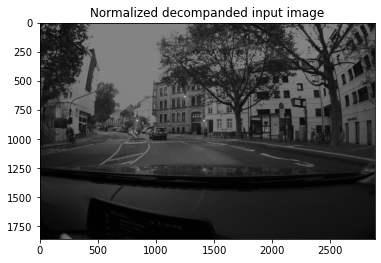

--------------------------------------------------------
Step 5: Apply Auto White Balance (AWB):
--------------------------------------------------------
Step 5.1: Compute the AWB weights:
The computed AWB weights:
[0.9605397575856383, 1.0, 0.9651146402636089]
Step completed successfully!

Step 5.2: Compute the AWB weights matrix:
Step completed successfully!

Step 5.3: Apply the AWB matrix on the normalized image:
Step completed successfully!


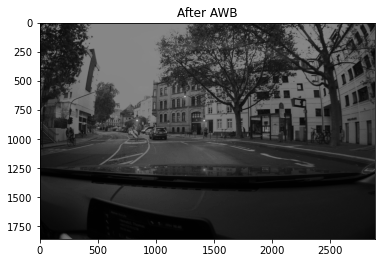

--------------------------------------------------------
Step 6: Apply DeBayering:
--------------------------------------------------------
Step completed successfully!


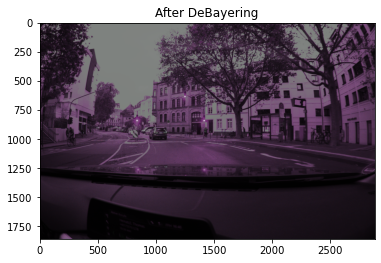

--------------------------------------------------------
Step 7: Apply Color-Correction:
--------------------------------------------------------
Step completed successfully!


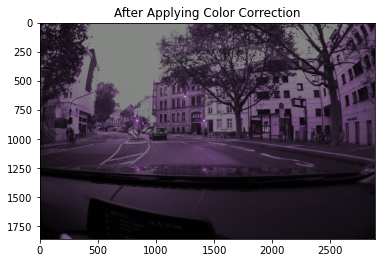

--------------------------------------------------------
Step 8: Brighten the Image:
--------------------------------------------------------
Step completed successfully!


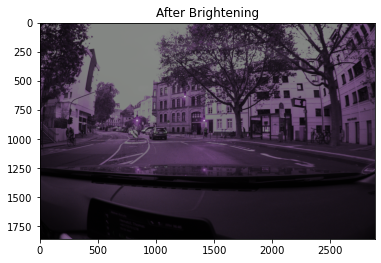

--------------------------------------------------------
Step 9:  Apply Gamma Correction:
--------------------------------------------------------
Step completed successfully!


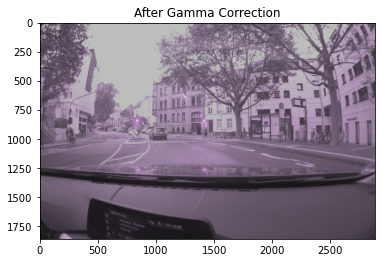

--------------------------------------------------------
Step 10: Apply HSV-Based Post-Processing:
--------------------------------------------------------
Step 10.1: Convert from RGB to HSV
Step completed successfully!
Step 10.2: Apply Histogram equalization on the V-channel
Step completed successfully!
Step 10.3: Suppress the Hue and Saturation to reduce the magenta cast artifacts
Step completed successfully!
Step 10.4: Convert from HSV back to RGB
Step completed successfully!


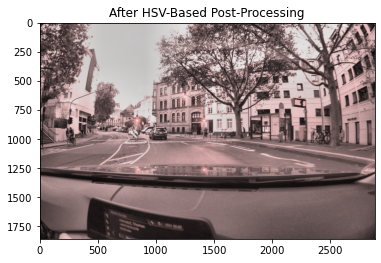

--------------------------------------------------------
Step 11: Save the final image:
--------------------------------------------------------
Successfully saved the final output RGB image to file: output\000.jpg




Processing raw-image #: 2, with file name = images\001.raw
--------------------------------------------------------
Step 1: Read the companded HDR RAW image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 2: De-compand the raw companded image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 3: Re-shape the decompaned image as 2D image array:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 4: Normalize the decompanded image to within the [0, 1] range:
-------------------------

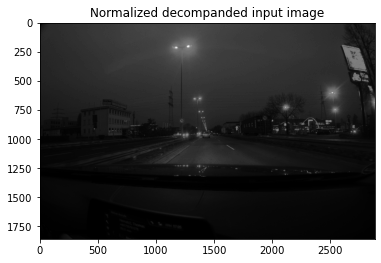

--------------------------------------------------------
Step 5: Apply Auto White Balance (AWB):
--------------------------------------------------------
Step 5.1: Compute the AWB weights:
The computed AWB weights:
[1.0, 1.0, 1.0]
Step completed successfully!

Step 5.2: Compute the AWB weights matrix:
Step completed successfully!

Step 5.3: Apply the AWB matrix on the normalized image:
Step completed successfully!


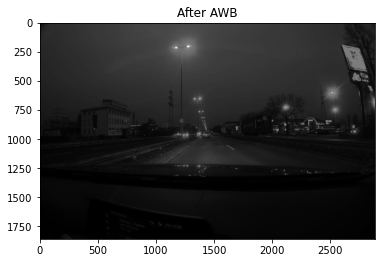

--------------------------------------------------------
Step 6: Apply DeBayering:
--------------------------------------------------------
Step completed successfully!


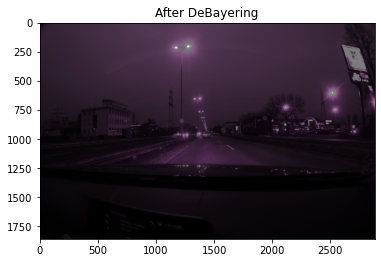

--------------------------------------------------------
Step 7: Apply Color-Correction:
--------------------------------------------------------
Step completed successfully!


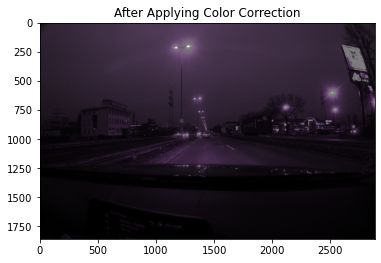

--------------------------------------------------------
Step 8: Brighten the Image:
--------------------------------------------------------
Step completed successfully!


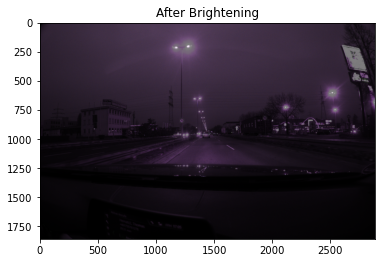

--------------------------------------------------------
Step 9:  Apply Gamma Correction:
--------------------------------------------------------
Step completed successfully!


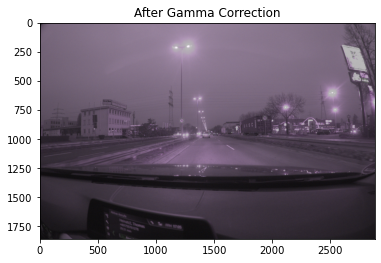

--------------------------------------------------------
Step 10: Apply HSV-Based Post-Processing:
--------------------------------------------------------
Step 10.1: Convert from RGB to HSV
Step completed successfully!
Step 10.2: Apply Histogram equalization on the V-channel
Step completed successfully!
Step 10.3: Suppress the Hue and Saturation to reduce the magenta cast artifacts
Step completed successfully!
Step 10.4: Convert from HSV back to RGB
Step completed successfully!


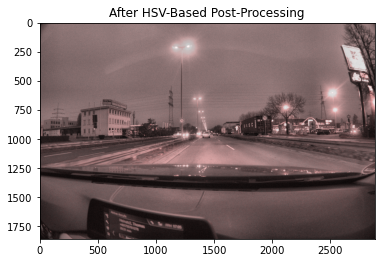

--------------------------------------------------------
Step 11: Save the final image:
--------------------------------------------------------
Successfully saved the final output RGB image to file: output\001.jpg




Processing raw-image #: 3, with file name = images\002.raw
--------------------------------------------------------
Step 1: Read the companded HDR RAW image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 2: De-compand the raw companded image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 3: Re-shape the decompaned image as 2D image array:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 4: Normalize the decompanded image to within the [0, 1] range:
-------------------------

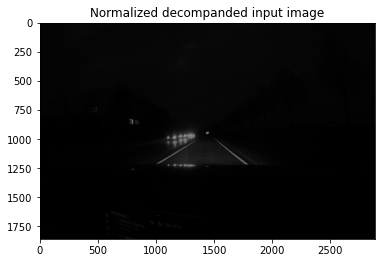

--------------------------------------------------------
Step 5: Apply Auto White Balance (AWB):
--------------------------------------------------------
Step 5.1: Compute the AWB weights:
The computed AWB weights:
[1.0007904229266036, 1.0, 1.0]
Step completed successfully!

Step 5.2: Compute the AWB weights matrix:
Step completed successfully!

Step 5.3: Apply the AWB matrix on the normalized image:
Step completed successfully!


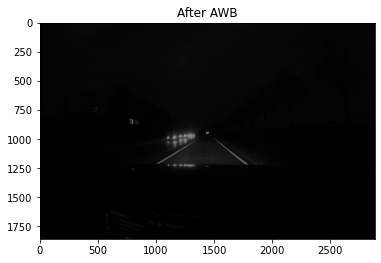

--------------------------------------------------------
Step 6: Apply DeBayering:
--------------------------------------------------------
Step completed successfully!


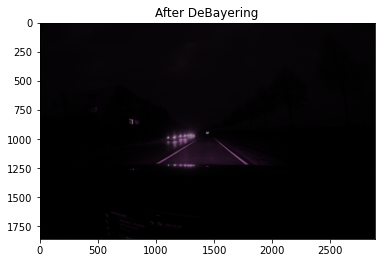

--------------------------------------------------------
Step 7: Apply Color-Correction:
--------------------------------------------------------
Step completed successfully!


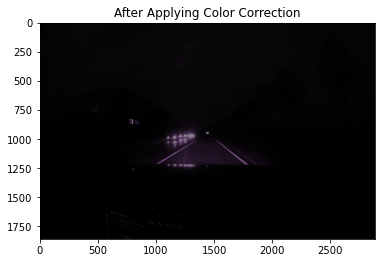

--------------------------------------------------------
Step 8: Brighten the Image:
--------------------------------------------------------
Step completed successfully!


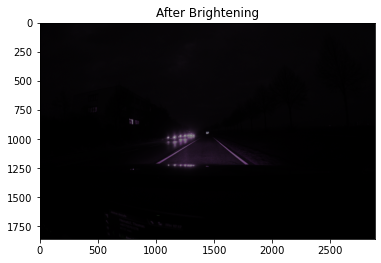

--------------------------------------------------------
Step 9:  Apply Gamma Correction:
--------------------------------------------------------
Step completed successfully!


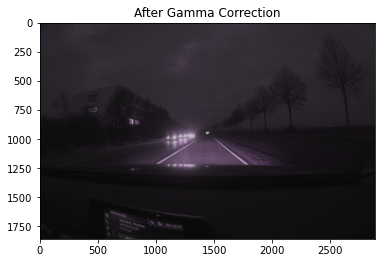

--------------------------------------------------------
Step 10: Apply HSV-Based Post-Processing:
--------------------------------------------------------
Step 10.1: Convert from RGB to HSV
Step completed successfully!
Step 10.2: Apply Histogram equalization on the V-channel
Step completed successfully!
Step 10.3: Suppress the Hue and Saturation to reduce the magenta cast artifacts
Step completed successfully!
Step 10.4: Convert from HSV back to RGB
Step completed successfully!


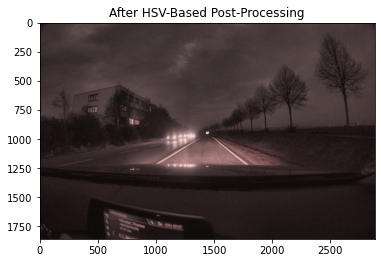

--------------------------------------------------------
Step 11: Save the final image:
--------------------------------------------------------
Successfully saved the final output RGB image to file: output\002.jpg




Processing raw-image #: 4, with file name = images\003.raw
--------------------------------------------------------
Step 1: Read the companded HDR RAW image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 2: De-compand the raw companded image:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 3: Re-shape the decompaned image as 2D image array:
--------------------------------------------------------
Step completed successfully!
--------------------------------------------------------
Step 4: Normalize the decompanded image to within the [0, 1] range:
-------------------------

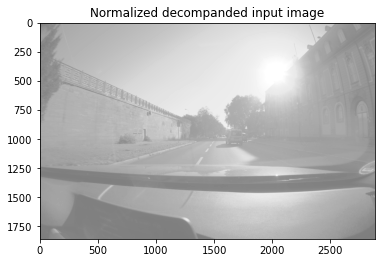

--------------------------------------------------------
Step 5: Apply Auto White Balance (AWB):
--------------------------------------------------------
Step 5.1: Compute the AWB weights:
The computed AWB weights:
[1.0, 1.0, 1.0]
Step completed successfully!

Step 5.2: Compute the AWB weights matrix:
Step completed successfully!

Step 5.3: Apply the AWB matrix on the normalized image:
Step completed successfully!


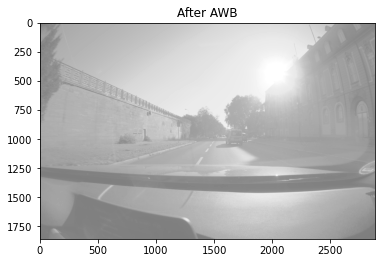

--------------------------------------------------------
Step 6: Apply DeBayering:
--------------------------------------------------------
Step completed successfully!


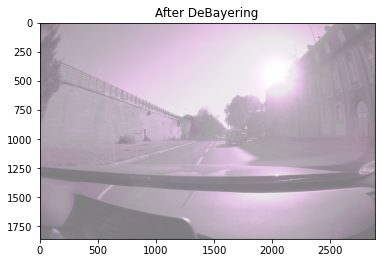

--------------------------------------------------------
Step 7: Apply Color-Correction:
--------------------------------------------------------
Step completed successfully!


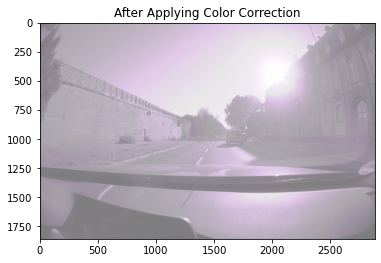

--------------------------------------------------------
Step 8: Brighten the Image:
--------------------------------------------------------
Step completed successfully!


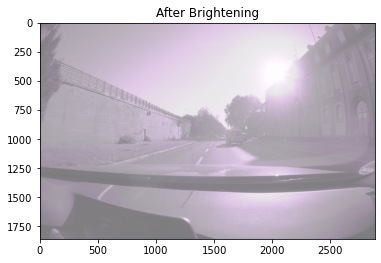

--------------------------------------------------------
Step 9:  Apply Gamma Correction:
--------------------------------------------------------
Step completed successfully!


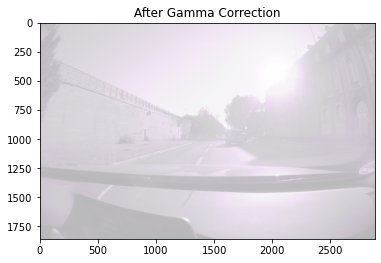

--------------------------------------------------------
Step 10: Apply HSV-Based Post-Processing:
--------------------------------------------------------
Step 10.1: Convert from RGB to HSV
Step completed successfully!
Step 10.2: Apply Histogram equalization on the V-channel
Step completed successfully!
Step 10.3: Suppress the Hue and Saturation to reduce the magenta cast artifacts
Step completed successfully!
Step 10.4: Convert from HSV back to RGB
Step completed successfully!


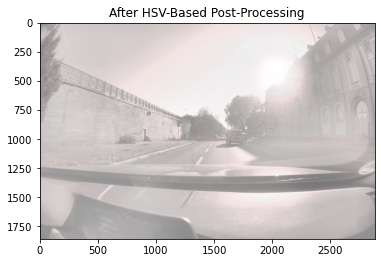

--------------------------------------------------------
Step 11: Save the final image:
--------------------------------------------------------
Successfully saved the final output RGB image to file: output\003.jpg


Program Execution Completed Successfully...Goodbye!


In [7]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from skimage.color import rgb2gray
import numpy as np
from PIL import *
import glob
import os
import cv2

#==================================================================
# This is the Driver Program:
#==================================================================
# This is the driver program which implements the following steps:
#
# 1) Read a companded RAW image from disk and return a linear RAW image. 
#
# 2) Implement a minimal image processing pipeline to convert the RAW 
#    images to RGB. 
#
#    The implemented pipeline has the following modules:
#
#    2.1) Linearization
#    2.2) Auto-White Balance (AWB)
#    2.3) DeBayering
#    2.4) Color space correction via CCM
#    2.5) Brightness correction
#    2.6) Gamma correction
#    2.7) Contrast enhancement via Adaptive Histogram Equalization 
#
# 3) Display or store the processed RGB image to disk.
#
#------------------------------------------------------------------
# History
#------------------------------------------------------------------
# Dec. 17th, 2020         Initial implementation
#------------------------------------------------------------------
# Dec. 22nd, 2020         Summary of changes:
#------------------------------------------------------------------
#                         - Edited and refactored code and added 
#                           comments, documentation and output 
#                           statements
#
#                         - Replaced pixels clipping with linear 
#                           scaling to within the interval: [0, 1]
#
#                         - Implemented a HSV-based post-processing 
#                           module, which consists of the following 
#                           transformations:
#
#                             - Suppress the pixel values of the the HSV 
#                               Hue and Saturation channels in order
#                               to reduce/remove the magenta cast
#
#                             - Apply Adaptive Histogram Equalization 
#                               on the Value-channel to enhance the 
#                               image contrast
#------------------------------------------------------------------
# Author: Mohsen Ghazel
#==================================================================

#==================================================================
# Set the fixed parameters/constants and user preferences
#==================================================================
# 1) Input image parameters
#------------------------------------------------------------------
# input raw image bit-depth
BITDEPTH = 16
# input image number of columns
COLS = 2880
# input image number of rows
ROWS = 1860
# input raw image number of header rows
HEADER_ROWS = 5
# input raw image number of trailer rows
TRAILER_ROWS = 6
# input raw image CFA pattern
CFA_ORDER = 'RGGB'

#------------------------------------------------------------------
# 2) Auto-White-Balance (AWB) implemented approaches:
#------------------------------------------------------------------
# - We implemented 2 simple AWB approaches:
#
#    - Approach-01: Gray-World Assumption
#    - Approach-02: White-World Assumption
#
# - These simple and quick AWB approaches were considered for 
#   this initial rapid prototyping.
#
# - Adaptive/histogram-based AWB approaches may be more 
#   suitable and may be explored in future work.
#------------------------------------------------------------------
# set awb_approach = 1: Approach-01: Gray-World Assumption
selected_awb_approach = 2

#------------------------------------------------------------------
# 3) Color conversion/transformation matrices:
#------------------------------------------------------------------
# Convert from RGB to sRGB colorspace matrix
#------------------------------------------------------------------
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
                    [0.2126729, 0.7151522, 0.0721750],
                    [0.0193339, 0.1191920, 0.9503041]])
#------------------------------------------------------------------
# Convert camera’s color space to the XYZ color space
#------------------------------------------------------------------
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
            [-0.4221, 1.3303, 0.0929],
            [-0.0881, 0.2416, 0.7226]])
  
#------------------------------------------------------------------
# 4) Gamma correction parameter: 
#------------------------------------------------------------------
# We apply gamma correction with gamma_value = 1/2.2
#------------------------------------------------------------------
gamma_correction_value = 1/2.2

#------------------------------------------------------------------
# 5) Parameters for shift and transform the HSV color space Hue 
#    and Saturation to reduce the magenta cast artifacts:
#------------------------------------------------------------------
# - These paramaters are determined via limited experimentation
# - Additional experimentation may be needed to set these paramaters 
#   to more optimal values, yielding better image quality.
#------------------------------------------------------------------
# Hue suppression shift value
hsv_hue_shift_value = -60 # (degrees)
# saturation suppression root exponent
hsv_saturation_root_exponent = 0.50
#------------------------------------------------------------------

#------------------------------------------------------------------
# 6) Input image counter
#------------------------------------------------------------------
image_counter = 0;
    
#==================================================================
# Iterate over all the input images in the 'images' sub-folder
#==================================================================
for img_filename in glob.glob('images\\*.raw'): # assuming .raw
    # increment the image counter
    image_counter += 1
    # display a message
    print('\n');
    print('========================================================')
    print('Processing raw-image #: ' + str(image_counter) + ', with file name = ' + img_filename)
    print('========================================================')
    print('--------------------------------------------------------')
    print('Step 1: Read the companded HDR RAW image:')
    print('--------------------------------------------------------')
    #--------------------------------------------------------------
    # Step 1: Read the companded HDR RAW image
    #--------------------------------------------------------------
    # can use numpy.fromfile to read the raw image
    raw_img = np.fromfile(img_filename, dtype=np.uint16, count = ROWS * COLS)
    # display successful execution message
    print('Step completed successfully!')
    
    #--------------------------------------------------------------
    # Step 2: De-compand the raw companded image
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 2: De-compand the raw companded image:')
    print('--------------------------------------------------------')
    # call the provided linearize() helper function
    decompanded_raw_img = linearize(raw_img)
    # display successful execution message
    print('Step completed successfully!')
    
    #--------------------------------------------------------------
    # Step 3: Re-shape the decompaned image as 2D image array
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 3: Re-shape the decompaned image as 2D image array:')
    print('--------------------------------------------------------')
    input_img = decompanded_raw_img.reshape(ROWS, COLS)
    # display successful execution message
    print('Step completed successfully!')
    
    #--------------------------------------------------------------
    # Step 4: Normalize the decompanded image to within the [0, 1] 
    #         range
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 4: Normalize the decompanded image to within the [0, 1] range:')
    print('--------------------------------------------------------')
    # 4.1) first, make a copy of the image in double format
    input_img = np.array(input_img).astype(np.double)
    # 4.2) Normalize image to between 0 and 1
    input_img_normalized = ( input_img - np.min( input_img )) / ( np.max( input_img ) - np.min( input_img ) )
    # display successful execution message
    print('Step completed successfully!')
    # 4.3) display the image
    plt.imshow(input_img_normalized , cmap='gray')
    # 4.4) set the figure title
    plt.title('Normalized decompanded input image')
    # 4.5) show the figure
    plt.show()
    
    #--------------------------------------------------------------
    # Step 5: Apply Auto White Balance (AWB)
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 5: Apply Auto White Balance (AWB):')
    print('--------------------------------------------------------')
    #--------------------------------------------------------------
    # 5.1) Compute AWB weights for each of the R, G, B 
    #      channels based on one of the following 2 methods:
    #
    #       - selected_awb_approach = 1: Gray-World Assumption
    #       - selected_awb_approach = 2: White-World Assumption
    #--------------------------------------------------------------
    # - The parameter selected_awb_approach is set above
    #--------------------------------------------------------------
    print('Step 5.1: Compute the AWB weights:')
    # call the compute_awb_weights() function to compute the AWB weights
    awb_weights = compute_awb_weights(input_img_normalized, CFA_ORDER, selected_awb_approach)
    # print the computed AWB weights
    print('The computed AWB weights:')
    print(awb_weights)
    # display successful execution message
    print('Step completed successfully!')
          
    #--------------------------------------------------------------
    # 5.2) Compute the AWB mask
    #--------------------------------------------------------------
    print('\nStep 5.2: Compute the AWB weights matrix:')
    # compute the AWB weights matrix
    awb_weights_matrix = compute_awb_weights_matrix(ROWS, COLS, awb_weights, CFA_ORDER)
    # display successful execution message
    print('Step completed successfully!')
          
    #--------------------------------------------------------------
    # 5.3) Apply the AWB matrix on the normalized image
    #--------------------------------------------------------------
    print('\nStep 5.3: Apply the AWB matrix on the normalized image:')
    # apply the AWB by scaling the image by the computed awb_weights_mask
    img_normalized_balanced = np.multiply(input_img_normalized, awb_weights_matrix)
    # display successful execution message
    print('Step completed successfully!')
    # display the image
    plt.imshow(img_normalized_balanced, cmap='gray')
    # figure title
    plt.title('After AWB')
    # show the figure
    plt.show()

    #--------------------------------------------------------------
    # Step 6: Apply DeBayering
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 6: Apply DeBayering:')
    print('--------------------------------------------------------')
    # call the debayering function()
    img_debayered = apply_debayering(img_normalized_balanced, CFA_ORDER)
    # display successful execution message
    print('Step completed successfully!')
    # display the image
    plt.imshow(img_debayered)
    # set the figure title
    plt.title('After DeBayering')
    # view the DeBayered image
    plt.show()
   
    #--------------------------------------------------------------
    # Step 7: Color Correction:
    #--------------------------------------------------------------
    # - The current RGB image is viewable with the standard Python 
    #   display functions. 
    # - However, its pixels will not have coordinates in the correct 
    #   RGB space that is expected by display system. 
    # - The pixel’s RGB valuesneed to be converted to some color basis 
    #   which the display monitor expects. 
    # - This is done by a linear transformation, so we will need to apply 
    #   a 3x3 matrix transformation to each of the pixels.
    # - The correct matrix to apply can be difficult to find. 
    # - We use Adobe color conversion matrices which transform from the 
    #   camera’s color space to the XYZ color space, a common standard. 
    # - Then the transformation from XYZ to the desired output space, sRGB, can be applied. 
    # - We can also combine these two transformations and then apply them once.
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 7: Apply Color-Correction:')
    print('--------------------------------------------------------')
    # 7.1) Combine the two color space transformation matrices into one matrix 
    #      color correction matrix (CCM) to be applied once.
    rgb2cam = xyz2cam * rgb2xyz 
    # 7.2) reshape the CCM matrix
    denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
    # 7.3) normalize CCM matrix between 0 and 1
    rgb2cam = np.divide(rgb2cam, denom) 
    # 7.4) invert the CCM matrix 
    cam2rgb = np.linalg.inv(rgb2cam)
    # 7.5) apply the color conversion matrix on the debayered image
    img_srgb = apply_ccm_matrix(img_debayered, cam2rgb)
    # 7.6) normalize the image to within [0, 1]
    normalized_img_srgb = ( img_srgb - np.min( img_srgb )) / ( np.max( img_srgb ) - np.min( img_srgb ) )
    # display successful execution message
    print('Step completed successfully!')
    # 7.7) display the color-corrected image
    plt.imshow(normalized_img_srgb)
    # 7.7) set the figure title
    plt.title('After Applying Color Correction')
    # 7.8) show the figure
    plt.show()
    
    #--------------------------------------------------------------
    # Step 8: Brighten the Image
    #--------------------------------------------------------------
    # - We now have a 16-bit, RGB image that has been color corrected 
    #   and exists in the right color space for display. 
    # - However, its pixel values may not be in a range appropriate 
    #   for being displayed. 
    # - We can brighten the image by simply scaling it 
    # - Next, we apply a simple brightening approach which
    #   ensures that the mean luminance of the image is scaled
    #   to a reasonable value.
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 8: Brighten the Image:')
    print('--------------------------------------------------------')
    # 8.1) Convert img_srgb to grayscale
    gray_img_srgb = rgb2gray(normalized_img_srgb);
    # 8.2) compute the scale value of the image so that the mean luminance is 1/4 the maximum
    grayscale_value = 0.25/np.mean(gray_img_srgb.reshape(ROWS * COLS, 1));
    # 8.3) scale the img_srgb by the grayscale_value
    bright_img_srgb = normalized_img_srgb * grayscale_value;
    # 8.4) normalize the image to within [0, 1]
    bright_img_srgb = ( bright_img_srgb - np.min( bright_img_srgb )) / ( np.max( bright_img_srgb ) - np.min( bright_img_srgb ) )
    # display successful execution message
    print('Step completed successfully!')
    # 8.5)  display the image
    plt.imshow(bright_img_srgb)
    # 8.6) figure title
    plt.title('After Brightening')
    # 8.7) show the figure
    plt.show()
    
    #--------------------------------------------------------------
    # Step 9: Apply Gamma Correction
    #--------------------------------------------------------------
    # - Finally, the image is still linear, which is not suitable
    #   for display (dark areas will appear too dark)
    # - We will apply a “gamma correction” power function to this image 
    #  as a simple way to fix this with typical: gamma_value = 1/2.2
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 9:  Apply Gamma Correction:')
    print('--------------------------------------------------------')
    # 9.1) apply gamma correction with gamma_value = 1/2.2
    img_gamma_corrected = np.power(bright_img_srgb/float(np.max(bright_img_srgb)), gamma_correction_value)
    # 9.2) normalize the image to within [0, 1] range
    normalized_img_gamma_corrected =  ( img_gamma_corrected - np.min( img_gamma_corrected )) / ( np.max( img_gamma_corrected ) - np.min( img_gamma_corrected ) )
    # display successful execution message
    print('Step completed successfully!')
    # 9.2) display the image
    plt.imshow(normalized_img_gamma_corrected)
    # 9.3) set figure title
    plt.title('After Gamma Correction')
    # 9.4) show the figure
    plt.show()
    
    #--------------------------------------------------------------
    # Step 10: Apply HSV-Based Post-Processing in order to:
    #
    #          - Reduce mangenta cast 
    #          - Enhance contrast
    #--------------------------------------------------------------
    # 10.1) Convert from RGB to HSV color space and get the 
    #       Value-channel:
    #-------------------------------------------------------------
    # - The RGB is converted to the HSV color space
    #--------------------------------------------------------------
    # 10.2) Apply Contrast-Enhancement via Adaptive Histogram Equalization 
    #       on the Value-Channel ONLY:
    #--------------------------------------------------------------
    # - We apply localized Adaptive Histogram Equalization on the Value-channel 
    #   to enhance details over small areas in an image rather than the 
    #   whole image. 
    # - The Adaptive Histogram Equalization is applied ONLY on
    #   the Value-channel, because it corresponds to illumintaion
    #   and brightness measurement
    # - This is done by applying a transformation 
    #   function that is derived from the neighborhood of every 
    #   pixel in the image
    # - This is exactly what Adaptive Histogram Equalization (AHE) in 
    #   OpenCV does:
    #
    #    - In Adaptive Histogram Equalization (AHE), the image is 
    #       divided into small blocks called “tiles”:
    #    - Tiles  of size 8×8 is a common choice). 
    #    - Then each of these blocks is histogram equalized. 
    #    - Finally, the enhanced blocks together using bilinear 
    #      interpolation.
    #--------------------------------------------------------------
    # 10.3) Suppress the Hue and Saturation pixel-values to reduce 
    #       the magenta cast artifacts
    #--------------------------------------------------------------
    # - Magenta color has high Hue and Saturdation pixel values
    # - Suppressing the values of Hue and Saturation should reduce 
    #   the magenta artifacts:
    #   - Hue can be reduce via a shift function (subtraction)
    #   - Saturation can be reduved via a root-function
    #--------------------------------------------------------------
    # 10.4) Convert from HSV to RGB aflter applying Adaptive 
    #       Histogram Equalization on the Value-Channel.
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 10: Apply HSV-Based Post-Processing:')
    print('--------------------------------------------------------')
    #--------------------------------------------------------------
    # 10.1) Convert from RGB to HSV color space and get the 
    #       Value-channel:
    #-------------------------------------------------------------
    # - The RGB is converted to the HSV color space
    # - The following Adaptive Histogram Equalization is applied on
    #   the Value-channel, because it corresponds to illumintaion
    #   and brightness measurement
    #--------------------------------------------------------------
    print('Step 10.1: Convert from RGB to HSV')
    # scale the image to [0, 255]
    scaled_img_gamma_corrected = 255 * normalized_img_gamma_corrected
    # convert type to unit8
    scaled_img_gamma_corrected = scaled_img_gamma_corrected.astype(np.uint8)
    # convert image from RGB to HSV
    img_hsv = cv2.cvtColor(scaled_img_gamma_corrected , cv2.COLOR_RGB2HSV)
    # display successful execution message
    print('Step completed successfully!')

    #--------------------------------------------------------------
    # 10.2) Apply Contrast-Limited Adaptive Histogram Equalization 
    #       on the Value-Channel ONLY:
    #--------------------------------------------------------------
    # - We apply localized histogram equalization on the Value-channel 
    #   to enhance details over small areas in an image rather than the 
    #   whole image. 
    # - This is done by applyinga transformation 
    #   function that is derived from the neighborhood of every 
    #   pixel in the image
    # - This is exactly what Adaptive Histogram Equalization (AHE) in 
    #   OpenCV does:
    #
    #    - In Adaptive Histogram Equalization (AHE), the image is 
    #       divided into small blocks called “tiles”:
    #    - Tiles  of size 8×8 is a common choice). 
    #    - Then each of these blocks is histogram equalized. 
    #    - Finally, the enhanced blocks together using bilinear 
    #      interpolation.
    #--------------------------------------------------------------
    print('Step 10.2: Apply Histogram equalization on the V-channel')
    # create a CLAHE tile object 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # - Apply the contrast-limited adaptive Histogram Equalization 
    #   on the Value-channel
    img_hsv[:, :, 2] = clahe.apply(img_hsv[:, :, 2])
    # display successful execution message
    print('Step completed successfully!')
    
    #--------------------------------------------------------------
    # 10.3) Suppress the Hue and Saturation to reduce the magenta cast 
    #       artifacts
    #--------------------------------------------------------------
    print('Step 10.3: Suppress the Hue and Saturation to reduce the magenta cast artifacts')
    #--------------------------------------------------------------
    # Magenta cast color has high Hue and Saturtaion pixel values:
    #--------------------------------------------------------------
    # Magenta color code: 
    #--------------------------------------------------------------
    # (R, G, B) = (255, 0, 255)
    # (H, S, V) = (300 degs, 100%, 100%)
    #--------------------------------------------------------------
    # As defined previously, the parameters for shift and transform 
    # the HSV color space Hue and Saturation to reduce the magenta 
    # cast artifacts:
    #--------------------------------------------------------------
    # - These paramaters are determined via limited experimentation
    # - Additional experimentation may be needed to set these paramaters 
    #   to more optimal values, yielding better image quality.
    #--------------------------------------------------------------
    # Hue suppression shift value
    # hsv_hue_shift_value = -60 # (degrees)
    # saturation suppression root exponent
    # hsv_saturation_root_exponent = 0.50
    #--------------------------------------------------------------
    # - Reduce the Hue channel via shifting, as follows:
    #--------------------------------------------------------------
    img_hsv[:, :, 0] = (img_hsv[:, :, 0] + hsv_hue_shift_value / 360.0) % 1.0
    #--------------------------------------------------------------
    # - Reduce the Saturation channe via square-root, as follows:
    #-------------------------------------------------------------
    img_hsv[:, :, 0] = img_hsv[:, :, 0]**hsv_saturation_root_exponent
    # display successful execution message
    print('Step completed successfully!')
    
    #--------------------------------------------------------------
    # 10.4) Convert from HSV to RGB after applying Adaptive 
    #       Histogram Equalization on the Value-Channel.
    #--------------------------------------------------------------
    print('Step 10.4: Convert from HSV back to RGB')
    # convert image back from HSV to RGB
    enhanced_rgb_image = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    # normalize the enhanced image to [0, 255]
    normalized_enhanced_rgb_image = cv2.normalize(enhanced_rgb_image, None, 0, 255, cv2.NORM_MINMAX)
    # display successful execution message
    print('Step completed successfully!')
    plt.imshow(normalized_enhanced_rgb_image)
    plt.title('After HSV-Based Post-Processing')
    plt.show()
   
    #--------------------------------------------------------------
    # Step 11: Save the final image
    #--------------------------------------------------------------
    print('--------------------------------------------------------')
    print('Step 11: Save the final image:')
    print('--------------------------------------------------------')
    # 10.1) set the final RGB image
    final_rgb_img = normalized_enhanced_rgb_image
    # 10.2) create the output file name
    head, tail = os.path.split(img_filename)
    # 10.3) set output image file name
    output_img_filename = 'output' + '\\' + tail[0:-4] + '.jpg'
    # 10.4) save the final 
    matplotlib.image.imsave(output_img_filename, final_rgb_img)
    # 10.5) display a message
    print('Successfully saved the final output RGB image to file: ' + output_img_filename)
    print('\n');
    
print('===========================================================')
print('Program Execution Completed Successfully...Goodbye!')
print('===========================================================') 
    